In [ ]:
!pip install gymnasium[atari,accept-rom-license] ale-py

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym 

In [3]:
from gymnasium.wrappers import AtariPreprocessing, FrameStack

In [4]:
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')
env = AtariPreprocessing(env, 
                         grayscale_obs=True, 
                         scale_obs=True, 
                         frame_skip=1,
                        screen_size=64)
env = FrameStack(env, num_stack=4)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [5]:
obs, _ = env.reset()
obs_space = env.observation_space.shape[0]
act_space = env.action_space

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, 4, stride=2),
            nn.ELU(),
            nn.Conv2d(32, 64, 4, 2),
            nn.ELU(),
            nn.Conv2d(64, 128, 4, 2),
            nn.ELU(),
            nn.Conv2d(128, 256, 4, 2),
            nn.ELU()
        )
        self.fc = nn.Linear(256*2*2, latent_dim)
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [7]:
class RSSM(nn.Module):
    def __init__(self, num_cats=32, cat_dim=32, hidden_dim=200, action_dim=4):
        super().__init__()
        self.num_cats = num_cats
        self.cat_dim = cat_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim

        self.rnn = nn.GRU(num_cats*cat_dim + action_dim, hidden_dim)
        self.fc_prior = nn.Linear(hidden_dim, num_cats*cat_dim)
        self.fc_post = nn.Linear(hidden_dim + 2048, num_cats*cat_dim)

    def gumbel_softmax_sample(self, logits, tau=1.0):
        logits = logits.view(-1, self.num_cats, self.cat_dim)
    
        noise = -torch.log(-torch.log(torch.rand_like(logits) + 1e-20) + 1e-20)
        y = logits + noise
        y_soft = F.softmax(y / tau, dim=-1)  # softmax over cat_dim for each slot
        
        # STE 
        index = y_soft.argmax(dim=-1, keepdim=True)
        y_hard = torch.zeros_like(y_soft).scatter_(-1, index, 1.0)
        
        # Flatten back to (B, num_cats * cat_dim)
        result = (y_hard + (y_soft - y_soft.detach())).view(-1, self.num_cats * self.cat_dim)
        return result

    def forward_prior(self, h, a, z_prev):
        x = torch.cat([z_prev, a], dim=-1)
        h_next, _ = self.rnn(x.unsqueeze(0), h.unsqueeze(0))
        logits = self.fc_prior(h_next.squeeze(0))
        z_prior = self.gumbel_softmax_sample(logits)
        return z_prior, h_next.squeeze(0), logits

    def forward_post(self, h, a, e, z_prev):
        x = torch.cat([z_prev, a], dim=-1)
        h_next, _ = self.rnn(x.unsqueeze(0), h.unsqueeze(0))
        logits = self.fc_post(torch.cat([h_next.squeeze(0), e], dim=-1))
        z_post = self.gumbel_softmax_sample(logits)
        return z_post, h_next.squeeze(0), logits

In [8]:
class ObsDecoder(nn.Module):
    def __init__(self, hidden_dim=200, stochastic_dim=2048):
        super().__init__()
        latent_dim = hidden_dim + stochastic_dim  # 2248
        self.fc = nn.Linear(latent_dim, 256*4*4)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ELU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ELU(),
            nn.ConvTranspose2d(32, 1, 4, 2, padding=1)
        )
    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 256, 4, 4)
        return self.net(x)


In [9]:
class RewardDecoder(nn.Module):
    def __init__(self, hidden_dim=200, stochastic_dim=2048):
        super().__init__()
        latent_dim = hidden_dim + stochastic_dim
        self.fc = nn.Linear(latent_dim, 1)
    def forward(self, z):
        return self.fc(z)

In [10]:
class DiscountDecoder(nn.Module):
    def __init__(self, hidden_dim=200, stochastic_dim=2048):
        super().__init__()
        latent_dim = hidden_dim + stochastic_dim
        self.fc = nn.Linear(latent_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, z):
        return self.sigmoid(self.fc(z))

In [11]:
class Buffer():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer= []
    def push(self, obs, action, reward, discount):
        obs = torch.tensor(np.array(obs), dtype=torch.float32)/255.0
        reward = torch.tensor(np.array(reward), dtype=torch.float32)
        action = torch.tensor(np.array(action), dtype=torch.float32)
        discount = torch.tensor(np.array(discount), dtype=torch.float32)
        self.buffer.append((
            obs, reward, action, discount
        ))
        if len(self.buffer) > self.capacity:
            raise ValueError('Buffer is full increase buffer size')

    def sample(self, batch_size, seq_len):
        sequences = []

        max_start = len(self.buffer) - seq_len 
        if max_start <=0:
            raise ValueError('Not enough data to sample sequences')

        for _ in range(batch_size):
            start_idx = np.random.randint(0, max_start)
            seq = self.buffer[start_idx: start_idx + seq_len]

            obs_seq, reward_seq, action_seq, discount_seq = zip(*seq)
            sequences.append((
                torch.stack(obs_seq),
                torch.stack(action_seq),
                torch.stack(reward_seq),
                torch.stack(discount_seq)
            ))
        obs_batch = torch.stack([s[0] for s in sequences])
        action_batch = torch.stack([s[1] for s in sequences])
        reward_batch = torch.stack([s[2] for s in sequences])
        discount_batch = torch.stack([s[3] for s in sequences])

        return obs_batch, action_batch, reward_batch, discount_batch

    def __len__(self):
        return len(self.buffer)

In [12]:
import numpy as np
import torch.nn.functional as F

In [13]:
buffer = Buffer(capacity=20000)


obs, _ = env.reset()
obs = np.array(obs)
n_actions = env.action_space.n
for _ in range(5000):
    action = env.action_space.sample()
    obs_next, reward, done, truncated, info = env.step(action)
    obs_next = np.array(obs_next)

    discount = 0.0 if done or truncated else 1.0
    action_onehot = F.one_hot(torch.tensor(action), num_classes=n_actions)
    buffer.push(obs, action_onehot, reward, discount)

    obs = obs_next

    if done or truncated:
        obs, _ = env.reset()
        obs = np.array(obs)

In [28]:
def loss_fn(x_pred, x_true, r_pred, r_true, d_pred, d_true,
           prior_logits, post_logits, num_cats=64, cat_dim=32):
    obs_loss = ((x_pred - x_true)**2).mean()
    reward_loss = ((r_pred-r_true)**2).mean()
    discount_loss = ((d_pred - d_true)**2).mean()
    
    prior_logits = prior_logits.view(-1, num_cats, cat_dim)
    post_logits = post_logits.view(-1, num_cats, cat_dim)
    
    q = F.softmax(post_logits, dim=-1)
    log_q = F.log_softmax(post_logits, dim=-1)
    p = F.softmax(prior_logits, dim=-1)
    
    kl_loss = (q * (log_q - torch.log(p + 1e-8))).sum(-1).mean()  
    total_loss = obs_loss + reward_loss + discount_loss + kl_loss
    return total_loss, obs_loss, reward_loss, discount_loss, kl_loss

In [29]:
device = 'cuda'

In [30]:
batch_size = 16
seq_len = 50
h_dim = 200
num_cats = 64
cat_dim = 32
latent_dim = 2048


In [31]:
encoder=Encoder(latent_dim=latent_dim).to(device)
rssm = RSSM(num_cats=num_cats, cat_dim=cat_dim, action_dim=n_actions).to(device)
obs_decoder = ObsDecoder(hidden_dim=h_dim, stochastic_dim=num_cats*cat_dim).to(device)
reward_decoder = RewardDecoder(hidden_dim=h_dim, stochastic_dim=num_cats*cat_dim).to(device)
discount_decoder = DiscountDecoder(hidden_dim=h_dim, stochastic_dim=num_cats*cat_dim).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters())+
                            list(rssm.parameters())+
                            list(reward_decoder.parameters())+
                            list(obs_decoder.parameters())+
                             list(discount_decoder.parameters()), lr=1e-3)

In [32]:
from tqdm import trange

In [33]:
# In your training loop:
for step in trange(4000):
    obs_batch, action_batch, reward_batch, discount_batch = buffer.sample(batch_size, seq_len)
    obs_batch = obs_batch.to(device)
    action_batch = action_batch.to(device)
    reward_batch = reward_batch.to(device)
    discount_batch = discount_batch.to(device)
    
    loss_total = 0.0 
    h_seq = torch.zeros(batch_size, h_dim).to(device)
    z_prev = torch.zeros(batch_size, num_cats * cat_dim).to(device)
    
    for t in range(seq_len):
        obs_t = obs_batch[:, t]
        a_t = action_batch[:, t]
        r_t = reward_batch[:, t]
        d_t = discount_batch[:, t]
        
        # Encode
        e_t = encoder(obs_t)
        
        # RSSM forward
        z_post, h_seq, post_logits = rssm.forward_post(h_seq, a_t, e_t, z_prev)
        z_prior, _, prior_logits = rssm.forward_prior(h_seq, a_t, z_prev)
        
        # Decode using posterior
        latent = torch.cat([h_seq, z_post], dim=-1)  # concatenate h and z
        x_pred = obs_decoder(latent)
        r_pred = reward_decoder(latent).squeeze(-1)
        d_pred = discount_decoder(latent).squeeze(-1)
        
        # Compute loss
        loss, obs_loss, reward_loss, discount_loss, kl_loss = loss_fn(
            x_pred, obs_t, r_pred, r_t, d_pred, d_t, 
            prior_logits, post_logits, num_cats, cat_dim  
        )
        loss_total += loss

        
        z_prev = z_post.detach()
        h_seq = h_seq.detach()
    
    optimizer.zero_grad()
    (loss_total / seq_len).backward()
    torch.nn.utils.clip_grad_norm_(
        list(encoder.parameters()) + 
        list(rssm.parameters()) + 
        list(obs_decoder.parameters()) + 
        list(reward_decoder.parameters()) +
        list(discount_decoder.parameters()), 
        100.0
    )
    optimizer.step()
    
    if step % 50 == 0:
        print(f"Step {step}, Loss: {loss_total.item()/seq_len:.4f}")

  0%|          | 1/4000 [00:00<30:23,  2.19it/s]

Step 0, Loss: 0.3038


  1%|▏         | 51/4000 [00:19<26:18,  2.50it/s]

Step 50, Loss: 0.0196


  3%|▎         | 101/4000 [00:39<25:54,  2.51it/s]

Step 100, Loss: 0.0129


  4%|▍         | 151/4000 [00:58<25:23,  2.53it/s]

Step 150, Loss: 0.0169


  5%|▌         | 201/4000 [01:17<25:06,  2.52it/s]

Step 200, Loss: 0.0100


  6%|▋         | 251/4000 [01:37<24:47,  2.52it/s]

Step 250, Loss: 0.0136


  8%|▊         | 301/4000 [01:56<24:30,  2.52it/s]

Step 300, Loss: 0.0110


  9%|▉         | 351/4000 [02:15<24:05,  2.52it/s]

Step 350, Loss: 0.0134


 10%|█         | 401/4000 [02:35<23:27,  2.56it/s]

Step 400, Loss: 0.0115


 11%|█▏        | 451/4000 [02:54<23:26,  2.52it/s]

Step 450, Loss: 0.0124


 13%|█▎        | 501/4000 [03:13<22:56,  2.54it/s]

Step 500, Loss: 0.0148


 14%|█▍        | 551/4000 [03:32<23:55,  2.40it/s]

Step 550, Loss: 0.0145


 15%|█▌        | 601/4000 [03:52<22:27,  2.52it/s]

Step 600, Loss: 0.0119


 16%|█▋        | 651/4000 [04:11<22:00,  2.54it/s]

Step 650, Loss: 0.0180


 18%|█▊        | 701/4000 [04:30<21:27,  2.56it/s]

Step 700, Loss: 0.0157


 19%|█▉        | 751/4000 [04:49<21:12,  2.55it/s]

Step 750, Loss: 0.0159


 20%|██        | 801/4000 [05:08<20:53,  2.55it/s]

Step 800, Loss: 0.0108


 21%|██▏       | 851/4000 [05:27<20:11,  2.60it/s]

Step 850, Loss: 0.0107


 23%|██▎       | 901/4000 [05:46<19:56,  2.59it/s]

Step 900, Loss: 0.0108


 24%|██▍       | 951/4000 [06:05<20:14,  2.51it/s]

Step 950, Loss: 0.0143


 25%|██▌       | 1001/4000 [06:25<19:26,  2.57it/s]

Step 1000, Loss: 0.0118


 26%|██▋       | 1051/4000 [06:44<19:03,  2.58it/s]

Step 1050, Loss: 0.0071


 28%|██▊       | 1101/4000 [07:03<19:14,  2.51it/s]

Step 1100, Loss: 0.0179


 29%|██▉       | 1151/4000 [07:22<18:43,  2.54it/s]

Step 1150, Loss: 0.0143


 30%|███       | 1201/4000 [07:41<18:33,  2.51it/s]

Step 1200, Loss: 0.0094


 31%|███▏      | 1251/4000 [08:00<18:04,  2.53it/s]

Step 1250, Loss: 0.0130


 33%|███▎      | 1301/4000 [08:19<17:34,  2.56it/s]

Step 1300, Loss: 0.0115


 34%|███▍      | 1351/4000 [08:38<17:19,  2.55it/s]

Step 1350, Loss: 0.0168


 35%|███▌      | 1401/4000 [08:57<16:54,  2.56it/s]

Step 1400, Loss: 0.0118


 36%|███▋      | 1451/4000 [09:16<16:34,  2.56it/s]

Step 1450, Loss: 0.0096


 38%|███▊      | 1501/4000 [09:35<16:13,  2.57it/s]

Step 1500, Loss: 0.0131


 39%|███▉      | 1551/4000 [09:54<16:12,  2.52it/s]

Step 1550, Loss: 0.0083


 40%|████      | 1601/4000 [10:13<15:46,  2.53it/s]

Step 1600, Loss: 0.0117


 41%|████▏     | 1651/4000 [10:33<15:30,  2.52it/s]

Step 1650, Loss: 0.0163


 43%|████▎     | 1701/4000 [10:52<15:03,  2.54it/s]

Step 1700, Loss: 0.0156


 44%|████▍     | 1751/4000 [11:12<14:40,  2.55it/s]

Step 1750, Loss: 0.0145


 45%|████▌     | 1801/4000 [11:31<14:14,  2.57it/s]

Step 1800, Loss: 0.0120


 46%|████▋     | 1851/4000 [11:50<13:58,  2.56it/s]

Step 1850, Loss: 0.0156


 48%|████▊     | 1901/4000 [12:09<13:38,  2.57it/s]

Step 1900, Loss: 0.0101


 49%|████▉     | 1951/4000 [12:28<13:17,  2.57it/s]

Step 1950, Loss: 0.0138


 50%|█████     | 2001/4000 [12:47<12:53,  2.59it/s]

Step 2000, Loss: 0.0109


 51%|█████▏    | 2051/4000 [13:06<12:38,  2.57it/s]

Step 2050, Loss: 0.0117


 53%|█████▎    | 2101/4000 [13:25<12:14,  2.59it/s]

Step 2100, Loss: 0.0105


 54%|█████▍    | 2151/4000 [13:44<11:52,  2.59it/s]

Step 2150, Loss: 0.0130


 55%|█████▌    | 2201/4000 [14:03<11:48,  2.54it/s]

Step 2200, Loss: 0.0116


 56%|█████▋    | 2251/4000 [14:22<11:29,  2.54it/s]

Step 2250, Loss: 0.0106


 58%|█████▊    | 2301/4000 [14:41<11:10,  2.53it/s]

Step 2300, Loss: 0.0117


 59%|█████▉    | 2351/4000 [15:00<10:39,  2.58it/s]

Step 2350, Loss: 0.0105


 60%|██████    | 2401/4000 [15:19<10:16,  2.59it/s]

Step 2400, Loss: 0.0092


 61%|██████▏   | 2451/4000 [15:38<09:58,  2.59it/s]

Step 2450, Loss: 0.0131


 63%|██████▎   | 2501/4000 [15:57<09:42,  2.57it/s]

Step 2500, Loss: 0.0118


 64%|██████▍   | 2551/4000 [16:16<09:23,  2.57it/s]

Step 2550, Loss: 0.0128


 65%|██████▌   | 2601/4000 [16:35<09:05,  2.56it/s]

Step 2600, Loss: 0.0074


 66%|██████▋   | 2651/4000 [16:54<08:41,  2.59it/s]

Step 2650, Loss: 0.0031


 68%|██████▊   | 2701/4000 [17:13<08:36,  2.52it/s]

Step 2700, Loss: 0.0078


 69%|██████▉   | 2751/4000 [17:33<08:07,  2.56it/s]

Step 2750, Loss: 0.0095


 70%|███████   | 2801/4000 [17:51<07:42,  2.59it/s]

Step 2800, Loss: 0.0128


 71%|███████▏  | 2851/4000 [18:11<07:38,  2.51it/s]

Step 2850, Loss: 0.0116


 73%|███████▎  | 2901/4000 [18:30<07:17,  2.51it/s]

Step 2900, Loss: 0.0130


 74%|███████▍  | 2951/4000 [18:49<06:54,  2.53it/s]

Step 2950, Loss: 0.0106


 75%|███████▌  | 3001/4000 [19:09<06:40,  2.50it/s]

Step 3000, Loss: 0.0168


 76%|███████▋  | 3051/4000 [19:28<06:07,  2.58it/s]

Step 3050, Loss: 0.0092


 78%|███████▊  | 3101/4000 [19:47<05:48,  2.58it/s]

Step 3100, Loss: 0.0132


 79%|███████▉  | 3151/4000 [20:06<05:34,  2.53it/s]

Step 3150, Loss: 0.0141


 80%|████████  | 3201/4000 [20:25<05:12,  2.56it/s]

Step 3200, Loss: 0.0068


 81%|████████▏ | 3251/4000 [20:44<04:47,  2.61it/s]

Step 3250, Loss: 0.0092


 83%|████████▎ | 3301/4000 [21:03<04:33,  2.56it/s]

Step 3300, Loss: 0.0093


 84%|████████▍ | 3351/4000 [21:22<04:12,  2.57it/s]

Step 3350, Loss: 0.0183


 85%|████████▌ | 3401/4000 [21:41<04:01,  2.48it/s]

Step 3400, Loss: 0.0099


 86%|████████▋ | 3451/4000 [22:00<03:34,  2.56it/s]

Step 3450, Loss: 0.0057


 88%|████████▊ | 3501/4000 [22:19<03:15,  2.55it/s]

Step 3500, Loss: 0.0141


 89%|████████▉ | 3551/4000 [22:38<02:55,  2.56it/s]

Step 3550, Loss: 0.0154


 90%|█████████ | 3601/4000 [22:57<02:36,  2.55it/s]

Step 3600, Loss: 0.0140


 91%|█████████▏| 3651/4000 [23:16<02:16,  2.56it/s]

Step 3650, Loss: 0.0078


 93%|█████████▎| 3701/4000 [23:35<01:57,  2.54it/s]

Step 3700, Loss: 0.0154


 94%|█████████▍| 3751/4000 [23:54<01:38,  2.53it/s]

Step 3750, Loss: 0.0105


 95%|█████████▌| 3801/4000 [24:13<01:17,  2.57it/s]

Step 3800, Loss: 0.0109


 96%|█████████▋| 3851/4000 [24:33<00:58,  2.54it/s]

Step 3850, Loss: 0.0079


 98%|█████████▊| 3901/4000 [24:52<00:38,  2.55it/s]

Step 3900, Loss: 0.0148


 99%|█████████▉| 3951/4000 [25:11<00:19,  2.54it/s]

Step 3950, Loss: 0.0116


100%|██████████| 4000/4000 [25:29<00:00,  2.61it/s]


In [35]:
action_dim = env.action_space.n

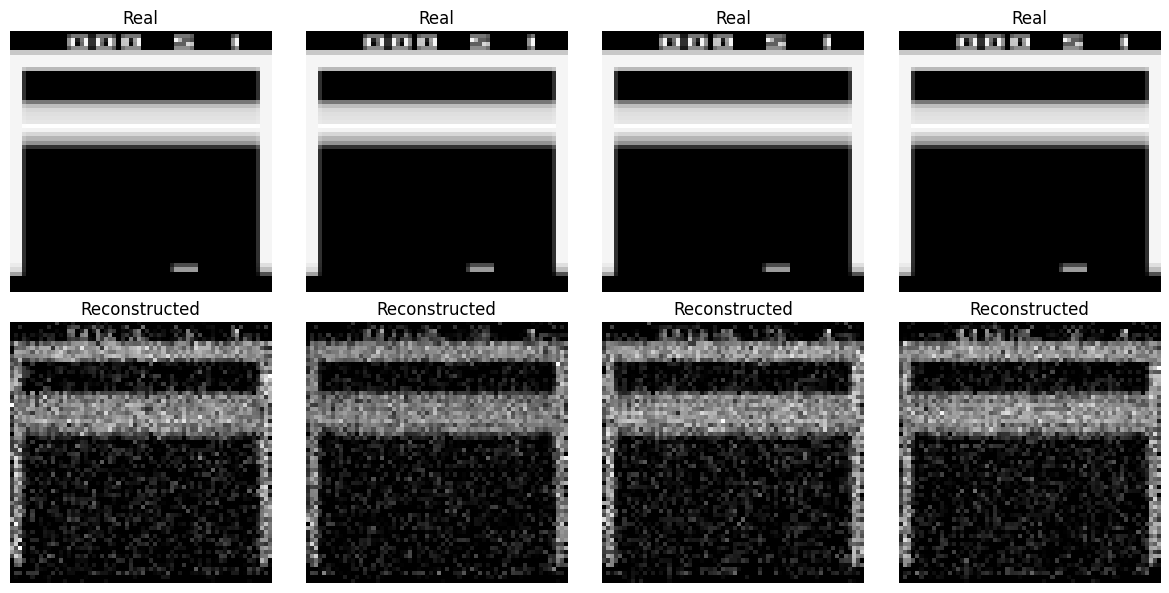

In [36]:
import matplotlib.pyplot as plt

obs_batch = torch.stack([buffer.buffer[i][0] for i in range(8)]).to(device)  # grab 8 frames

with torch.no_grad():
    e = encoder(obs_batch)
    
    h_seq = torch.zeros(obs_batch.size(0), h_dim).to(device)  # match batch size
    z_prev = torch.zeros(obs_batch.size(0), num_cats * cat_dim).to(device)
    
    dummy_action = torch.zeros(obs_batch.size(0), action_dim).to(device)
    
    z_post, h_seq, post_logits = rssm.forward_post(h_seq, dummy_action, e, z_prev)
    
    latent = torch.cat([h_seq, z_post], dim=-1)
    
    x_pred = obs_decoder(latent)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    axes[0, i].imshow(obs_batch[i, 0].cpu(), cmap='gray')
    axes[0, i].set_title("Real")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(x_pred[i, 0].cpu().clamp(0, 1), cmap='gray')  # clamp to [0,1] for display
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [52]:
torch.save(rssm, 'rssm3.pth')
torch.save(encoder, 'encoder3.pth')
torch.save(obs_decoder, 'obs_decoder3.pth')
torch.save(reward_decoder, 'reward_decoder3.pth')
torch.save(discount_decoder, 'discount_decoder3.pth')

In [ ]:
rssm = torch.load('/kaggle/input/models/pytorch/default/1/rssm2.pth', weights_only=False)
encoder =torch.load('/kaggle/input/models/pytorch/default/1/encoder2.pth', weights_only=False)
obs_decoder = torch.load('/kaggle/input/models/pytorch/default/1/obs_decoder2.pth', weights_only=False)
reward_decoder = torch.load('/kaggle/input/models/pytorch/default/1/reward_decoder2.pth', weights_only=False)
discount_decoder = torch.load('/kaggle/input/models/pytorch/default/1/discount_decoder2.pth', weights_only=False)

In [37]:
class Actor(nn.Module):
    def __init__(self, hidden_dim, stochastic_dim, action_dim):
        super().__init__()
        latent_dim = hidden_dim + stochastic_dim
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ELU(),
            nn.Linear(400, 400),
            nn.ELU(),
            nn.Linear(400, action_dim)
        )
    def forward(self, z):
        return torch.distributions.Categorical(logits=self.net(z))

In [38]:
class Critic(nn.Module):
    def __init__(self, hidden_dim, stochastic_dim):
        super().__init__()
        latent_dim = hidden_dim + stochastic_dim
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ELU(),
            nn.Linear(400, 400),
            nn.ELU(),
            nn.Linear(400, 1)
        )
    def forward(self, z):
        return self.net(z).squeeze(-1)

In [39]:
def rollout_with_logprobs(z_start, h_start, rssm, actor, horizon=15, action_dim=4):
    """Rollout and track log probabilities for policy gradient"""
    zs = []
    hs = []
    latents = []  # ADD: store concatenated latents
    actions = []
    log_probs = []
    entropies = []
    
    z = z_start
    h = h_start
    
    for _ in range(horizon):
        latent = torch.cat([h, z], dim=-1)
        
        dist = actor(latent)  
        a = dist.sample()
        log_prob = dist.log_prob(a)
        entropy = dist.entropy()
        
        a_onehot = F.one_hot(a, num_classes=action_dim).float()
        z_prior, h_next, _ = rssm.forward_prior(h, a_onehot, z)
        
        latents.append(latent)
        hs.append(h)
        zs.append(z)
        actions.append(a)
        log_probs.append(log_prob)
        entropies.append(entropy)
        
        z = z_prior
        h = h_next
    
    return (torch.stack(latents, 1),  # FIX: return concatenated latents
            torch.stack(actions, 1), 
            torch.stack(log_probs, 1),
            torch.stack(entropies, 1))

In [40]:
def compute_lambda_returns(rewards, values, discounts, lam=0.95, gamma=0.99):

    B, T = rewards.shape
    returns = torch.zeros_like(values)
    
    last_value = values[:, -1]  
    
    for t in reversed(range(T)):
        if t == T - 1:
            returns[:, t] = rewards[:, t] + discounts[:, t] * gamma * last_value
        else:
            next_return = returns[:, t + 1]
            next_value = values[:, t + 1]
            returns[:, t] = rewards[:, t] + discounts[:, t] * gamma * (
                (1 - lam) * next_value + lam * next_return
            )
    
    return returns

In [41]:
def update_ac(z_post, h_post, rssm, actor, critic,
              reward_decoder, discount_decoder,  
              actor_opt, critic_opt, horizon=15, lam=0.95, 
              entropy_weight=0.001, action_dim=4):
    
    latents, actions, log_probs, entropies = rollout_with_logprobs(
        z_post.detach(), h_post.detach(), rssm, actor, horizon, action_dim
    )
    
    rewards = reward_decoder(latents).squeeze(-1)  # FIX: use latents
    discounts = discount_decoder(latents).squeeze(-1)
    
    values = critic(latents.detach())
    
    targets = compute_lambda_returns(rewards.detach(), values, discounts.detach(), lam)
    
    critic_loss = ((values - targets.detach()) ** 2).mean()
    critic_opt.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(critic.parameters(), 100.0)
    critic_opt.step()
    
    values_for_actor = critic(latents)
    
    advantages = (targets.detach() - values_for_actor.detach())
    
    policy_loss = -(log_probs * advantages).mean()
    entropy_loss = -entropies.mean()
    
    actor_loss = policy_loss + entropy_weight * entropy_loss
    
    actor_opt.zero_grad()
    actor_loss.backward()
    torch.nn.utils.clip_grad_norm_(actor.parameters(), 100.0)
    actor_opt.step()
    
    return actor_loss.item(), critic_loss.item()

In [42]:
def sample_latent_batch(buffer, batch_size, encoder, rssm, device):
    obs_batch, act_batch, rew_batch, disc_batch = buffer.sample(batch_size, seq_len=50)
    obs_batch = obs_batch.to(device)
    act_batch = act_batch.to(device)
    B, T = act_batch.shape[0], act_batch.shape[1]
    
    e = encoder(obs_batch.reshape(B*T, *obs_batch.shape[2:]))
    e = e.reshape(B, T, -1)
    
    h = torch.zeros(B, rssm.hidden_dim, device=device)
    z_prev = torch.zeros(B, rssm.num_cats * rssm.cat_dim, device=device)
    
    for t in range(T):
        z_post, h, _ = rssm.forward_post(
            h,
            act_batch[:, t],
            e[:, t],
            z_prev
        )
        z_prev = z_post.detach() 
        h = h.detach()  
    
    return z_post, h

In [44]:
action_dim = n_actions  

actor = Actor(hidden_dim=h_dim, stochastic_dim=num_cats*cat_dim, action_dim=action_dim).to(device)
critic = Critic(hidden_dim=h_dim, stochastic_dim=num_cats*cat_dim).to(device)

actor_opt = torch.optim.Adam(actor.parameters(), lr=8e-5)  # Lower LR recommended
critic_opt = torch.optim.Adam(critic.parameters(), lr=8e-5)

for step in range(4000):
    z_post, h_post = sample_latent_batch(
        buffer=buffer, 
        batch_size=batch_size, 
        encoder=encoder, 
        rssm=rssm, 
        device=device
    )
    
    actor_loss, critic_loss = update_ac(
        z_post, h_post,
        rssm, actor, critic,
        reward_decoder, discount_decoder,  
        actor_opt, critic_opt,
        horizon=15,
        action_dim=action_dim  
    )
    
    if step % 10 == 0:
        print(f"step {step}, actor {actor_loss:.4f}, critic {critic_loss:.4f}")

step 0, actor -0.1027, critic 0.0071
step 10, actor -0.1163, critic 0.0036
step 20, actor 0.0668, critic 0.0027
step 30, actor 0.0080, critic 0.0026
step 40, actor -0.0390, critic 0.0016
step 50, actor 0.0033, critic 0.0011
step 60, actor 0.0183, critic 0.0009
step 70, actor -0.0170, critic 0.0023
step 80, actor 0.0013, critic 0.0025
step 90, actor 0.0085, critic 0.0019
step 100, actor -0.0090, critic 0.0020
step 110, actor -0.0018, critic 0.0019
step 120, actor 0.0011, critic 0.0022
step 130, actor 0.0182, critic 0.0014
step 140, actor 0.0031, critic 0.0024
step 150, actor -0.0148, critic 0.0016
step 160, actor 0.0127, critic 0.0019
step 170, actor -0.0248, critic 0.0019
step 180, actor -0.0061, critic 0.0013
step 190, actor 0.0028, critic 0.0018
step 200, actor 0.0222, critic 0.0023
step 210, actor -0.0137, critic 0.0024
step 220, actor -0.0034, critic 0.0016
step 230, actor 0.0107, critic 0.0023
step 240, actor 0.0075, critic 0.0015
step 250, actor -0.0198, critic 0.0014
step 260, a

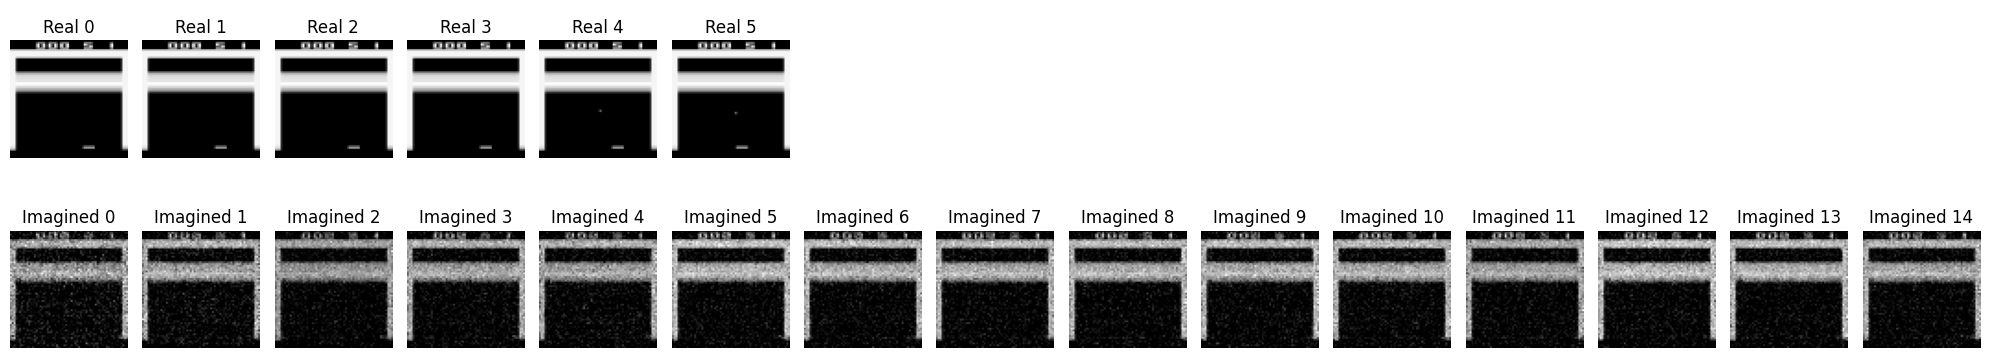

In [47]:
def visualize_imagination(env, encoder, rssm, obs_decoder, actor, device, horizon=15):
    """
    Show real vs imagined rollouts
    """
    obs, _ = env.reset()
    obs = np.array(obs)
    
    real_frames = [obs]
    for _ in range(5):
        action = env.action_space.sample()
        obs, _, done, truncated, _ = env.step(action)
        obs = np.array(obs)
        real_frames.append(obs)
        if done or truncated:
            break
    
    obs_tensor = torch.tensor(real_frames[-1], dtype=torch.float32).unsqueeze(0).to(device) / 255.0
    
    with torch.no_grad():
        e = encoder(obs_tensor)
        h = torch.zeros(1, rssm.hidden_dim).to(device)
        z_prev = torch.zeros(1, rssm.num_cats * rssm.cat_dim).to(device)
        
        z_post, h, _ = rssm.forward_post(h, torch.zeros(1, n_actions).to(device), e, z_prev)
        
        imagined_frames = []
        z = z_post
        
        for _ in range(horizon):
            latent = torch.cat([h, z], dim=-1)
            dist = actor(latent)
            action = dist.sample()
            action_onehot = F.one_hot(action, num_classes=n_actions).float()
            
            z_next, h, _ = rssm.forward_prior(h, action_onehot, z)
            
            latent_decode = torch.cat([h, z_next], dim=-1)
            img_pred = obs_decoder(latent_decode)
            imagined_frames.append(img_pred[0, 0].cpu().numpy())
            
            z = z_next
    
    fig, axes = plt.subplots(2, horizon, figsize=(20, 4))
    
    for i in range(horizon):
        if i < len(real_frames):
            axes[0, i].imshow(real_frames[i][0], cmap='gray')
            axes[0, i].set_title(f"Real {i}")
        else:
            axes[0, i].axis('off')
        
        axes[1, i].imshow(imagined_frames[i].clip(0, 1), cmap='gray')
        axes[1, i].set_title(f"Imagined {i}")
        
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig("imagination_rollout.png")
    plt.show()

visualize_imagination(env, encoder, rssm, obs_decoder, actor, device, horizon=15)

In [48]:
def test_agent(env, encoder, rssm, actor, device, num_episodes=5, render=False):
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(num_episodes):
        obs, _ = env.reset()
        obs = np.array(obs)
        done = False
        truncated = False
        
        total_reward = 0
        steps = 0
        
        h = torch.zeros(1, rssm.hidden_dim).to(device)
        z = torch.zeros(1, rssm.num_cats * rssm.cat_dim).to(device)
        
        frames = []  
        
        while not (done or truncated):
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device) / 255.0
            
            with torch.no_grad():
                e = encoder(obs_tensor)
                
                if steps == 0:
                    action_prev = torch.zeros(1, n_actions).to(device)
                
                z_post, h, _ = rssm.forward_post(h, action_prev, e, z)
                
                latent = torch.cat([h, z_post], dim=-1)
                
                dist = actor(latent)
                action = dist.sample().item()
                action_prev = F.one_hot(torch.tensor([action]), num_classes=n_actions).float().to(device)
            
            obs, reward, done, truncated, info = env.step(action)
            obs = np.array(obs)
            
            total_reward += reward
            steps += 1
            
            if render:
                frames.append(env.render())
            
            z = z_post
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        
        print(f"Episode {episode + 1}: Reward = {total_reward:.2f}, Steps = {steps}")
        
        if render and episode == 0:
            save_video(frames, f"test_episode_{episode}.mp4")
    
    print(f"Average Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"Average Length: {np.mean(episode_lengths):.2f} ± {np.std(episode_lengths):.2f}")
    print(f"Min/Max Reward: {np.min(episode_rewards):.2f} / {np.max(episode_rewards):.2f}")
    
    return episode_rewards, episode_lengths


def save_video(frames, filename, fps=30):
    import imageio
    imageio.mimsave(filename, frames, fps=fps)
    print(f"Video saved to {filename}")


test_env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')
test_env = AtariPreprocessing(test_env, 
                              grayscale_obs=True, 
                              scale_obs=True, 
                              frame_skip=1,
                              screen_size=64)
test_env = FrameStack(test_env, num_stack=4)

rewards, lengths = test_agent(
    test_env, 
    encoder, 
    rssm, 
    actor, 
    device, 
    num_episodes=10,
    render=True
)

/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Episode 1: Reward = 0.00, Steps = 138


Video saved to test_episode_0.mp4
Episode 2: Reward = 2.00, Steps = 201
Episode 3: Reward = 2.00, Steps = 206
Episode 4: Reward = 3.00, Steps = 284
Episode 5: Reward = 3.00, Steps = 233
Episode 6: Reward = 1.00, Steps = 177
Episode 7: Reward = 1.00, Steps = 175
Episode 8: Reward = 2.00, Steps = 208
Episode 9: Reward = 1.00, Steps = 181
Episode 10: Reward = 2.00, Steps = 199

=== Test Results ===
Average Reward: 1.70 ± 0.90
Average Length: 200.20 ± 36.89
Min/Max Reward: 0.00 / 3.00


In [49]:
def test_random_baseline(env, num_episodes=10):
    episode_rewards = []
    
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        truncated = False
        total_reward = 0
        
        while not (done or truncated):
            action = env.action_space.sample()
            obs, reward, done, truncated, _ = env.step(action)
            total_reward += reward
        
        episode_rewards.append(total_reward)
    
    print(f"Random Policy - Average Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    return episode_rewards

random_rewards = test_random_baseline(test_env, num_episodes=10)

Random Policy - Average Reward: 1.20 ± 1.17


In [51]:
print(f"Random Policy:  {np.mean(random_rewards):.2f} ± {np.std(random_rewards):.2f}")
print(f"Dreamer Agent:  {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
print(f"Improvement:    {((np.mean(rewards) - np.mean(random_rewards)) / np.mean(random_rewards) * 100):.1f}%")

Random Policy:  1.20 ± 1.17
Dreamer Agent:  1.70 ± 0.90
Improvement:    41.7%
